
Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as Func

In [3]:
data = pd.read_csv("MovieLens.csv")
print(data.head(10))

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
5       1       70     3.0  964982400
6       1      101     5.0  964980868
7       1      110     4.0  964982176
8       1      151     5.0  964984041
9       1      157     5.0  964984100


In [4]:
#fix the seed to make consistent
np.random.seed(4)

#separate the data into training and validation(testing)
mask = np.random.rand(len(data)) < 0.75
train = data[mask].copy()
val = data[~mask].copy()

In [5]:
def proc_col(col, train_col=None):
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [6]:
def encode_data(df, train=None):
    df = df.copy()
    for col_name in ["userId", "movieId"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [7]:
df_train = encode_data(train)
df_val = encode_data(val, train)
print(df_train.head(10))

    userId  movieId  rating  timestamp
1        0        0     4.0  964981247
3        0        1     5.0  964983815
4        0        2     5.0  964982931
5        0        3     3.0  964982400
7        0        4     4.0  964982176
8        0        5     5.0  964984041
9        0        6     5.0  964984100
11       0        7     5.0  964981208
14       0        8     4.0  964980908
15       0        9     5.0  964981680


Training Function

In [8]:
def train_epocs(model, epochs = 10, lr = 0.01, wd = 0.0):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)#using SGD to optimize
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) #using Adam to optimize
    model.train()
    for i in range(epochs):
        users = torch.LongTensor(df_train.userId.values)
        items = torch.LongTensor(df_train.movieId.values)
        ratings = torch.FloatTensor(df_train.rating.values)
        y_hat = model(users, items)
        loss = Func.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(loss.item())
    loss = test_loss(model)

    return loss

def test_loss(model):
    model.eval()
    users = torch.LongTensor(df_val.userId.values)
    items = torch.LongTensor(df_val.movieId.values)
    ratings = torch.FloatTensor(df_val.rating.values)
    y_hat = model(users, items)
    #print(y_hat,ratings)
    loss = Func.mse_loss(y_hat, ratings)
    print("The test MSE loss is %.2f " % loss.item())
    return loss.item()

In [9]:
num_users = len(df_train.userId.unique())
num_items = len(df_train.movieId.unique())
print(num_users,num_items)

610 8758


# **NeuMF**

In [10]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, hidden_size=10, final_size = 5):
        super(NeuMF, self).__init__()
        self.user_emb_GMF = nn.Embedding(num_users, emb_size)
        self.item_emb_GMF = nn.Embedding(num_items, emb_size)
        self.user_emb_MLP = nn.Embedding(num_users, emb_size)
        self.item_emb_MLP = nn.Embedding(num_items, emb_size)
        self.user_emb_MLP.weight.data.uniform_(0, 0.05)
        self.item_emb_MLP.weight.data.uniform_(0, 0.05)
        self.fc1 = nn.Linear(emb_size * 2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, final_size)
        self.drop = nn.Dropout(0.1) #drop out neruons to prevent overfitting
        self.prediction = nn.Linear(emb_size + final_size,1)
    def forward(self, u, v):
        u_M = self.user_emb_MLP(u)
        v_M = self.item_emb_MLP(v)
        x_M = torch.cat([u_M,v_M],dim = 1)
        x_M = self.drop(x_M)
        x_M = self.fc1(x_M)
        x_M = self.relu(x_M)
        x_M = self.fc2(x_M)


        u_G = self.user_emb_GMF(u)
        v_G = self.item_emb_GMF(v)
        x_G = (u_G * v_G)

        x = torch.cat([x_M,x_G], dim = 1)
        x = self.prediction(x)
        return x.squeeze()

baseline model

In [11]:
model_NeuMF = NeuMF(num_users, num_items)
train_epocs(model_NeuMF, epochs=10, lr=0.1)

The test MSE loss is 1.10 


1.0997157096862793

Perform Hyperparameter tuning for NeuMF under SGD

The learning rate is: 1e-06
The test MSE loss is 14.43 
The learning rate is: 1e-05
The test MSE loss is 14.56 
The learning rate is: 0.0001
The test MSE loss is 14.08 
The learning rate is: 0.001
The test MSE loss is 13.48 
The learning rate is: 0.01
The test MSE loss is 9.20 
The learning rate is: 0.1
The test MSE loss is 1.10 
The learning rate is: 0.9
The test MSE loss is nan 


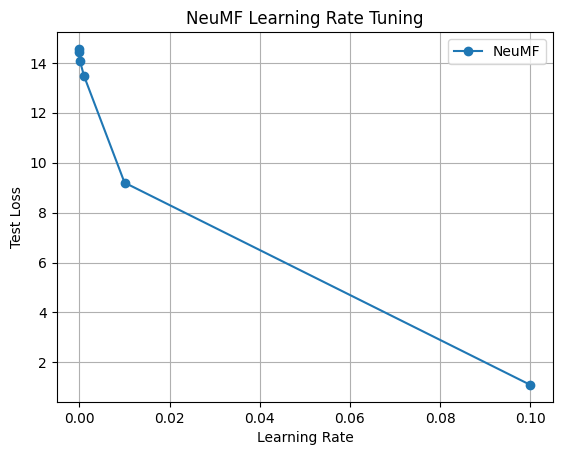

In [12]:
NeuMF_lr = [0.000001,0.00001,0.0001,0.001,0.01,0.1,0.9]
Neu_MF_lr_losses1 = []

for l in NeuMF_lr:
  model = NeuMF(num_users, num_items, emb_size=100,hidden_size=10, final_size = 5)
  print("The learning rate is:",l)
  loss = train_epocs(model, epochs=10, lr=l, wd = 0)
  Neu_MF_lr_losses1.append(loss)

plt.plot(NeuMF_lr, Neu_MF_lr_losses1, marker='o', label='NeuMF')
plt.title('NeuMF Learning Rate Tuning')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The learning rate is: 0.01
The test MSE loss is 8.00 
The learning rate is: 0.05
The test MSE loss is 1.17 
The learning rate is: 0.1
The test MSE loss is 1.10 
The learning rate is: 0.15
The test MSE loss is 1.09 
The learning rate is: 0.2
The test MSE loss is 1.09 


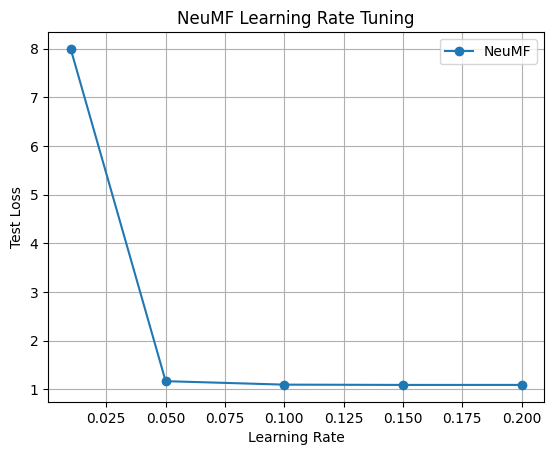

In [13]:
NeuMF_lr2 = [0.01,0.05,0.1,0.15,0.2]
Neu_MF_lr_losses2 = []

for l in NeuMF_lr2:
  model = NeuMF(num_users, num_items, emb_size=100,hidden_size=10, final_size = 5)
  print("The learning rate is:",l)
  loss = train_epocs(model, epochs=10, lr=l, wd = 0)
  Neu_MF_lr_losses2.append(loss)

plt.plot(NeuMF_lr2, Neu_MF_lr_losses2, marker='o', label='NeuMF')
plt.title('NeuMF Learning Rate Tuning')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The learning rate is: 0.11
The test MSE loss is 1.10 
The learning rate is: 0.13
The test MSE loss is 1.09 
The learning rate is: 0.15
The test MSE loss is 1.09 
The learning rate is: 0.17
The test MSE loss is 1.09 
The learning rate is: 0.19
The test MSE loss is 1.09 


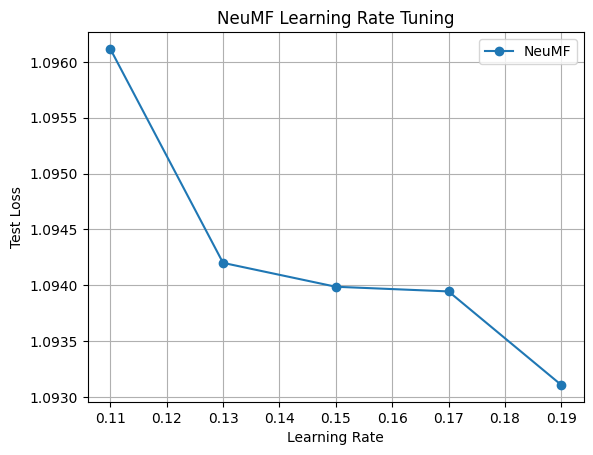

In [14]:
NeuMF_lr3 = [0.11,0.13,0.15,0.17,0.19]
Neu_MF_lr_losses3 = []

for l in NeuMF_lr3:
  model = NeuMF(num_users, num_items, emb_size=100,hidden_size=10, final_size = 5)
  print("The learning rate is:",l)
  loss = train_epocs(model, epochs=10, lr=l, wd = 0)
  Neu_MF_lr_losses3.append(loss)

plt.plot(NeuMF_lr3, Neu_MF_lr_losses3, marker='o', label='NeuMF')
plt.title('NeuMF Learning Rate Tuning')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

Hidden Size Tuning

The current hidden layer size is: 5
The test MSE loss is 1.09 
The current hidden layer size is: 10
The test MSE loss is 1.09 
The current hidden layer size is: 20
The test MSE loss is 1.09 
The current hidden layer size is: 30
The test MSE loss is 1.09 
The current hidden layer size is: 40
The test MSE loss is 1.09 
The current hidden layer size is: 50
The test MSE loss is 1.09 
The current hidden layer size is: 60
The test MSE loss is 1.09 
The current hidden layer size is: 70
The test MSE loss is 1.09 
The current hidden layer size is: 80
The test MSE loss is 1.09 
The current hidden layer size is: 90
The test MSE loss is 1.09 
The current hidden layer size is: 100
The test MSE loss is 1.09 
The current hidden layer size is: 200
The test MSE loss is 1.09 


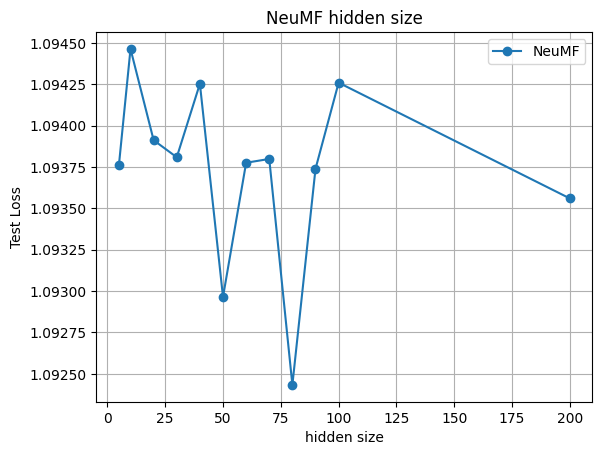

In [16]:
# the best lr = 0.15
NeuMF_hid_list = [5,10,20,30,40,50,60,70,80,90,100,200]
NeuMF_hid_list_loss = []

for i in NeuMF_hid_list:
  model = NeuMF(num_users, num_items, emb_size=100,hidden_size=i, final_size = 5)
  print("The current hidden layer size is:",i)
  NeuMF_hid_list_loss.append(train_epocs(model, epochs=10, lr=0.15, wd = 0))

plt.plot(NeuMF_hid_list, NeuMF_hid_list_loss, marker='o', label='NeuMF')
plt.title('NeuMF hidden size')
plt.xlabel('hidden size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The current hidden layer size is: 80
The test MSE loss is 1.09 
The current hidden layer size is: 85
The test MSE loss is 1.09 
The current hidden layer size is: 90
The test MSE loss is 1.09 
The current hidden layer size is: 95
The test MSE loss is 1.09 
The current hidden layer size is: 100
The test MSE loss is 1.09 
The current hidden layer size is: 105
The test MSE loss is 1.09 
The current hidden layer size is: 110
The test MSE loss is 1.09 


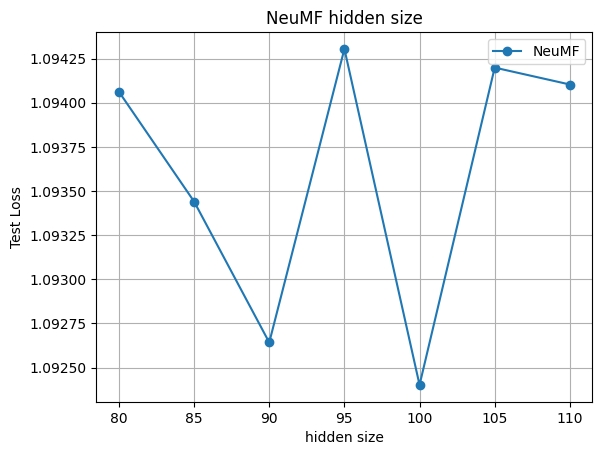

In [18]:
NeuMF_hid_list2 = [80,85,90,95,100,105,110]
NeuMF_hid_list_loss2 = []

for i in NeuMF_hid_list2:
  model = NeuMF(num_users, num_items, emb_size=100,hidden_size=i, final_size = 5)
  print("The current hidden layer size is:",i)
  NeuMF_hid_list_loss2.append(train_epocs(model, epochs=10, lr=0.15, wd = 0))

plt.plot(NeuMF_hid_list2, NeuMF_hid_list_loss2, marker='o', label='NeuMF')
plt.title('NeuMF hidden size')
plt.xlabel('hidden size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

Not much difference; however, when using Adam, the best teating loss has dropped under 1

Embedding Size Tuning

The current emb size is: 50
The test MSE loss is 1.09 
The current emb size is: 100
The test MSE loss is 1.09 
The current emb size is: 150
The test MSE loss is 1.09 
The current emb size is: 200
The test MSE loss is 1.10 
The current emb size is: 250
The test MSE loss is 1.09 
The current emb size is: 300
The test MSE loss is 1.10 


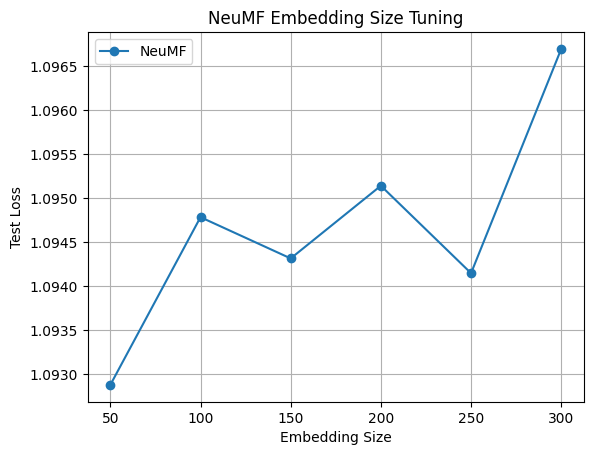

In [19]:
# the best lr = 0.15, the best hidden layer size = 100
NeuMF_emb_list = [50, 100, 150, 200, 250, 300]
NeuMF_emb_list_loss = []
for i in NeuMF_emb_list:
  model = NeuMF(num_users, num_items, emb_size=i,hidden_size=100, final_size = 5)
  print("The current emb size is:",i)
  NeuMF_emb_list_loss.append(train_epocs(model, epochs=10, lr=0.15, wd = 0))

plt.plot(NeuMF_emb_list, NeuMF_emb_list_loss, marker='o', label='NeuMF')
plt.title('NeuMF Embedding Size Tuning')
plt.xlabel('Embedding Size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

The current emb size is: 40
The test MSE loss is 1.09 
The current emb size is: 45
The test MSE loss is 1.09 
The current emb size is: 50
The test MSE loss is 1.09 
The current emb size is: 55
The test MSE loss is 1.09 
The current emb size is: 60
The test MSE loss is 1.09 
The current emb size is: 65
The test MSE loss is 1.09 


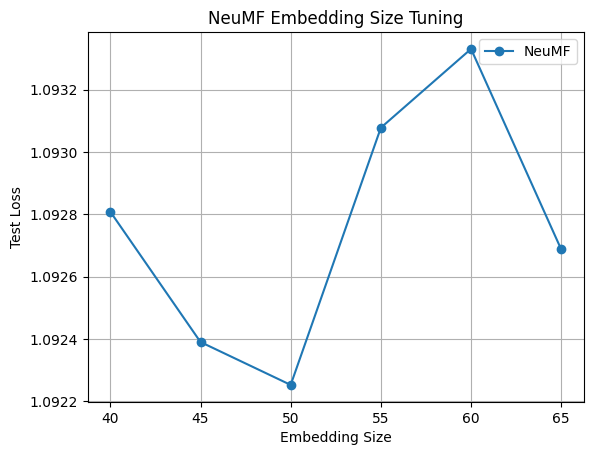

In [20]:
NeuMF_emb_list2 = [40,45,50,55,60,65]
NeuMF_emb_list_loss2 = []
for i in NeuMF_emb_list2:
  model = NeuMF(num_users, num_items, emb_size=i,hidden_size=100, final_size = 5)
  print("The current emb size is:",i)
  NeuMF_emb_list_loss2.append(train_epocs(model, epochs=10, lr=0.15, wd = 0))

plt.plot(NeuMF_emb_list2, NeuMF_emb_list_loss2, marker='o', label='NeuMF')
plt.title('NeuMF Embedding Size Tuning')
plt.xlabel('Embedding Size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

Final size tuning

The current final size is: 1
The test MSE loss is 1.09 
The current final size is: 2
The test MSE loss is 1.09 
The current final size is: 3
The test MSE loss is 1.09 
The current final size is: 4
The test MSE loss is 1.09 
The current final size is: 5
The test MSE loss is 1.09 
The current final size is: 6
The test MSE loss is 1.09 
The current final size is: 7
The test MSE loss is 1.09 
The current final size is: 8
The test MSE loss is 1.09 
The current final size is: 9
The test MSE loss is 1.09 
The current final size is: 10
The test MSE loss is 1.09 


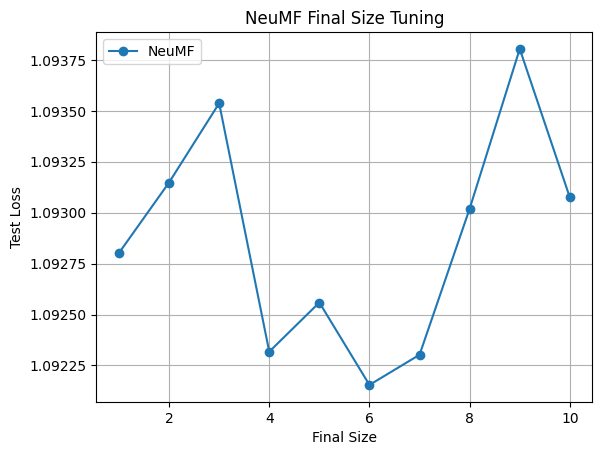

In [22]:
# the best lr = 0.15, the best hidden layer size = 100, the best embedding size is 50
NeuMF_final_list = [1,2,3,4,5,6,7,8,9,10]
NeuMF_final_list_loss = []
for i in NeuMF_final_list:
  model = NeuMF(num_users, num_items, emb_size=50,hidden_size=100, final_size = i)
  print("The current final size is:",i)
  NeuMF_final_list_loss.append(train_epocs(model, epochs=10, lr=0.15, wd = 0))

plt.plot(NeuMF_final_list, NeuMF_final_list_loss, marker='o', label='NeuMF')
plt.title('NeuMF Final Size Tuning')
plt.xlabel('Final Size')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()

weight decay

The weight decay is: 1e-06
The test MSE loss is 1.09 
The weight decay is: 1e-05
The test MSE loss is 1.09 
The weight decay is: 0.0001
The test MSE loss is 1.09 
The weight decay is: 0.001
The test MSE loss is 1.09 
The weight decay is: 0.01
The test MSE loss is 1.09 


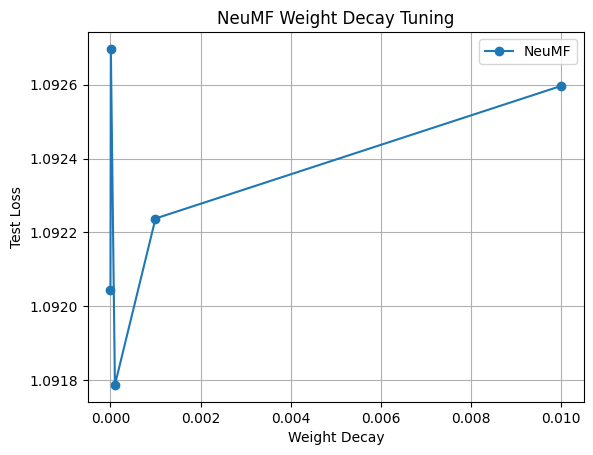

In [23]:
# the best lr = 0.15, the best hidden layer size = 100, the best embedding size is 50,final size = 6
NeuMF_weights = [0.000001,0.00001,0.0001, 0.001, 0.01]
NeuMF_weights_losses = []

for w in NeuMF_weights:
  model = NeuMF(num_users, num_items, emb_size=50,hidden_size=100, final_size = 6)
  print("The weight decay is:",w)
  loss = train_epocs(model, epochs=10, lr=0.15, wd = w)
  NeuMF_weights_losses.append(loss)

plt.plot(NeuMF_weights, NeuMF_weights_losses, marker='o', label='NeuMF')
plt.title('NeuMF Weight Decay Tuning')
plt.xlabel('Weight Decay')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)

plt.show()

Epoch

The Number of Epoch: 5
The test MSE loss is 1.10 
The Number of Epoch: 10
The test MSE loss is 1.09 
The Number of Epoch: 20
The test MSE loss is 1.09 
The Number of Epoch: 30
The test MSE loss is 1.09 
The Number of Epoch: 40
The test MSE loss is 1.09 
The Number of Epoch: 50
The test MSE loss is 1.09 


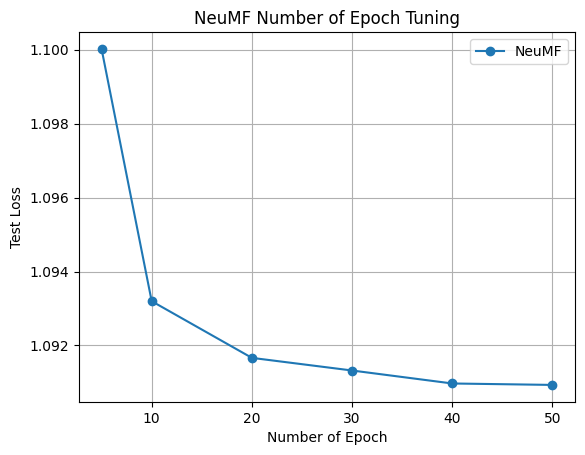

In [24]:
NeuMF_epoch = [5,10,20,30,40,50]
NeuMF_epoch_losses = []

for e in NeuMF_epoch:
  model = NeuMF(num_users, num_items, emb_size=50,hidden_size=100, final_size = 6)
  print("The Number of Epoch:",e)
  loss = train_epocs(model, epochs=e, lr=0.15, wd = 0.001)
  NeuMF_epoch_losses.append(loss)

plt.plot(NeuMF_epoch, NeuMF_epoch_losses, marker='o', label='NeuMF')
plt.title('NeuMF Number of Epoch Tuning')
plt.xlabel('Number of Epoch')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)

plt.show()